# Initialization

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load

In [2]:
from enum import StrEnum, auto


class SeasonType(StrEnum):
    CYCLIC = auto()
    CATEGORIES = auto()


In [3]:
SEASON_REPRESENTATION = SeasonType.CYCLIC


In [4]:
import sys

sys.path.append("../")  # go to parent dir
import os

from utils.common import CustomDataFrame

DATA_SRC = os.path.join("..", "Data")

path = os.path.join(DATA_SRC, "CSV", "train.csv")

data_df = CustomDataFrame(
    [path],
    index_col="id",
    target_cols=["sii"],
    no_null_cols=["sii"],
)


# Calcula el porcentaje de valores nulos por columna
nulls_info_load_ = data_df.null_percent()


| Total Rows: 3,960 | Rows with Nulls: 3,960 | Total Nulls: 131,717 | Nulls per Row: 33.26 | 


alt.Chart(...)

# Mi analisis

In [5]:
import pandas as pd

# Clean Data

### Remove Nulls (Columns/Rows)

In [6]:
from utils.common import Show

data_df = data_df.clean_nulls(0.5, show=Show.PLOT)
after_auto_clean_ = data_df.dataframe
display(after_auto_clean_)


Original Null Percentage
----------------------
| Total Rows: 3,960 | Rows with Nulls: 3,960 | Total Nulls: 131,717 | Nulls per Row: 33.26 | 


alt.Chart(...)

----------------------

After Dropping Rows with Null Values on NO_NULL_COLUMNS:
----------------------
['sii']
| Total Rows: 2,736 | Rows with Nulls: 2,736 | Total Nulls: 51,809 | Nulls per Row: 18.94 | 


alt.Chart(...)

----------------------

Columns to Drop due to Null Percentage | thresshold=50% |
----------------------
['Fitness_Endurance-Season', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'Physical-Waist_Circumference', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total']
| Total Rows: 2,736 | Rows with Nulls: 2,070 | Total Nulls: 29,840 | Nulls per Row: 14.42 | 


alt.Chart(...)

----------------------



id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,str,i64,i64,str,i64,str,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,str,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,"""Fall""",0,0,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,75,70,122,"""Fall""",3,0,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,65,94,117,"""Fall""",20,1,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,60,97,117,"""Summer""",18,1,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""001f3379""","""Spring""",13,1,"""Winter""",50,"""Summer""",22.279952,59.5,112.2,60,73,102,"""Summer""",12,0,6,0,10.0,1,11.0,1,8.0,0,"""Summer""",2,4.33036,30.1865,1330.97,1996.45,30.2124,84.0285,16.6877,13.4988,67.9715,2,32.9141,20.902,79.6982,35.3804,63.1265,"""Spring""",4.11,"""Summer""",3,3,3,0,2,1,0,2,2,1,0,1,3,3,2,1,3,1,2,1,34,"""Summer""",40,56,"""Spring""",0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff6c2bb8""","""Fall""",8,0,null,null,"""Fall""",17.13981,52.5,67.2,60,65,112,"""Fall""",0,0,0,0,8.0,1,10.0,1,12.0,1,"""Fall""",3,3.20303,17.1417,1035.27,1759.96,11.0063,52.5331,13.4004,3.7413,14.6669,1,25.7118,15.815,49.3301,20.2645,36.7181,"""Fall""",3.44,"""Fall""",3,3,3,0,0,0,0,3,0,0,0,0,2,0,0,3,0,2,2,1,22,"""Fall""",41,58,"""Fall""",2,0
"""ff759544""","""Summer""",7,1,null,null,"""Summer""",13.927006,48.5,46.6,65,75,105,"""Summer""",0,0,0,0,9.0,0,8.5,0,4.5,0,"""Fall""",1,2.3668,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.4147,1,20.0572,15.14,42.8185,18.0937,30.0453,null,null,"""Summer""",1,3,3,0,3,0,0,0,0,0,3,0,5,1,0,5,3,3,3,0,33,"""Summer""",48,67,"""Summer""",0,1
"""ff8a2de4""","""Fall""",13,0,"""Spring""",60,"""Fall""",16.

### Manual Remove Columns

In [7]:
from pprint import pprint

drop_columns = [
    # LEKEA EL TARGET
    "PCIAT-PCIAT_Total",
    "PCIAT-PCIAT_01",
    "PCIAT-PCIAT_02",
    "PCIAT-PCIAT_03",
    "PCIAT-PCIAT_04",
    "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06",
    "PCIAT-PCIAT_07",
    "PCIAT-PCIAT_08",
    "PCIAT-PCIAT_09",
    "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11",
    "PCIAT-PCIAT_12",
    "PCIAT-PCIAT_13",
    "PCIAT-PCIAT_14",
    "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16",
    "PCIAT-PCIAT_17",
    "PCIAT-PCIAT_18",
    "PCIAT-PCIAT_19",
    "PCIAT-PCIAT_20",
]
#  display(data.dataframe.columns)

print(f"Columns Count BEFORE DROP: {len(data_df.dataframe.columns)}")
data_df.dataframe = data_df.dataframe.drop([
    col for col in drop_columns if col in data_df.dataframe.columns
])

print(f"Columns Count AFTER DROP: {len(data_df.dataframe.columns)}")
print()

print(f"Data Shape: {data_df.dataframe.shape}")
print("Data Columns:")
pprint(data_df.dataframe.columns)

data_df.null_percent()

data_null_cols_clean_ = data_df.dataframe
display(data_null_cols_clean_)


Columns Count BEFORE DROP: 71
Columns Count AFTER DROP: 50

Data Shape: (2736, 50)
Data Columns:
['id',
 'Basic_Demos-Enroll_Season',
 'Basic_Demos-Age',
 'Basic_Demos-Sex',
 'CGAS-Season',
 'CGAS-CGAS_Score',
 'Physical-Season',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'FGC-Season',
 'FGC-FGC_CU',
 'FGC-FGC_CU_Zone',
 'FGC-FGC_PU',
 'FGC-FGC_PU_Zone',
 'FGC-FGC_SRL',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL',
 'FGC-FGC_TL_Zone',
 'BIA-Season',
 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_BMC',
 'BIA-BIA_BMI',
 'BIA-BIA_BMR',
 'BIA-BIA_DEE',
 'BIA-BIA_ECW',
 'BIA-BIA_FFM',
 'BIA-BIA_FFMI',
 'BIA-BIA_FMI',
 'BIA-BIA_Fat',
 'BIA-BIA_Frame_num',
 'BIA-BIA_ICW',
 'BIA-BIA_LDM',
 'BIA-BIA_LST',
 'BIA-BIA_SMM',
 'BIA-BIA_TBW',
 'PAQ_C-Season',
 'PAQ_C-PAQ_C_Total',
 'PCIAT-Season',
 'SDS-Season',
 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T',
 'PreInt_EduHx-Season',
 'PreInt_EduHx-

alt.Chart(...)

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,str,i64,i64,str,i64,str,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,str,f64,str,str,i64,i64,str,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,"""Fall""",0,0,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,"""Fall""",null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,75,70,122,"""Fall""",3,0,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,"""Fall""",2.34,"""Fall""","""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,65,94,117,"""Fall""",20,1,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""","""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,60,97,117,"""Summer""",18,1,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,"""Winter""",2.451,"""Summer""","""Summer""",31,45,"""Winter""",0,1
"""001f3379""","""Spring""",13,1,"""Winter""",50,"""Summer""",22.279952,59.5,112.2,60,73,102,"""Summer""",12,0,6,0,10.0,1,11.0,1,8.0,0,"""Summer""",2,4.33036,30.1865,1330.97,1996.45,30.2124,84.0285,16.6877,13.4988,67.9715,2,32.9141,20.902,79.6982,35.3804,63.1265,"""Spring""",4.11,"""Summer""","""Summer""",40,56,"""Spring""",0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff6c2bb8""","""Fall""",8,0,null,null,"""Fall""",17.13981,52.5,67.2,60,65,112,"""Fall""",0,0,0,0,8.0,1,10.0,1,12.0,1,"""Fall""",3,3.20303,17.1417,1035.27,1759.96,11.0063,52.5331,13.4004,3.7413,14.6669,1,25.7118,15.815,49.3301,20.2645,36.7181,"""Fall""",3.44,"""Fall""","""Fall""",41,58,"""Fall""",2,0
"""ff759544""","""Summer""",7,1,null,null,"""Summer""",13.927006,48.5,46.6,65,75,105,"""Summer""",0,0,0,0,9.0,0,8.5,0,4.5,0,"""Fall""",1,2.3668,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.4147,1,20.0572,15.14,42.8185,18.0937,30.0453,null,null,"""Summer""","""Summer""",48,67,"""Summer""",0,1
"""ff8a2de4""","""Fall""",13,0,"""Spring""",60,"""Fall""",16.36246,59.5,82.4,71,70,104,"""Fall""",16,0,10,1,8.0,1,9.0,1,12.0,1,"""Fall""",3,4.52277,16.3642,1206.88,2051.7,19.4611,70.8117,14.0629,2.30138,11.5883,1,33.3709,17.9797,66.2889,29.779,52.832,"""Winter""",3.26,"""Winter""","""Winter""",35,50,"""Fall""",1,1


### Convert Columns

In [8]:
import polars as pl
import polars.selectors as cs

from utils.transform import cyclic_transform, date_to_cyclic

data_df.column_distribution("sii")
display(data_df["sii"].unique().sort())

ciclyc_date_columns = []
for col in ciclyc_date_columns:
    if col not in data_df.dataframe.columns:
        continue
    if data_df.dataframe[col].dtype == pl.String:
        data_df.dataframe = data_df.dataframe.with_columns(pl.col(col).str.to_datetime())
    data_df.dataframe = date_to_cyclic(data_df.dataframe, col, fill_nan=False)

seasson_columns = [
    # ("column_name", max_value),
    "Basic_Demos-Enroll_Season",
    "CGAS-Season",
    "Physical-Season",
    "FGC-Season",
    "BIA-Season",
    "PAQ_C-Season",
    "PCIAT-Season",
    "SDS-Season",
    "PreInt_EduHx-Season",
]
SEASSON_DICT = {
    "Winter": 1.0,
    "Spring": 2.0,
    "Summer": 3.0,
    "Fall": 4.0,
}

if SEASON_REPRESENTATION == SeasonType.CYCLIC:
    for col in seasson_columns:
        data_df.with_columns(
            pl.col(col).map_elements(lambda x: SEASSON_DICT.get(x, None), return_dtype=pl.Float32)
        )
        data_df.dataframe = cyclic_transform(data_df.dataframe, col, 4.0, fill_nan=False)

print("String Columns:", data_df.get_columns_types().get(pl.String))

non_str_categories_columns = []
for col in non_str_categories_columns:
    data_df.with_columns(pl.col(col).cast(pl.String))

data_df.with_columns(cs.string().cast(pl.Categorical))
new_types = data_df.get_columns_types()
print("New Types: ")
pprint(new_types)
if True:
    dummy_vars: list[str] = []
    dummy_vars += new_types.get(pl.Categorical("physical"), [])
    dummy_vars += new_types.get(pl.Categorical("lexical"), [])
    dummy_vars = [col for col in dummy_vars if col not in data_df.target_cols]

    data_df.dataframe = data_df.dataframe.to_dummies(dummy_vars, drop_first=True)

    after_dummies_ = data_df.dataframe
    display(after_dummies_)


alt.Chart(...)

sii
i64
0
1
2
3


Data Types: {Int64: 19, Float64: 21, Float32: 18}
String Columns: None
Data Types: {Int64: 19, Float64: 21, Float32: 18}
New Types: 
{Float32: ['Basic_Demos-Enroll_Season_sin',
           'Basic_Demos-Enroll_Season_cos',
           'CGAS-Season_sin',
           'CGAS-Season_cos',
           'Physical-Season_sin',
           'Physical-Season_cos',
           'FGC-Season_sin',
           'FGC-Season_cos',
           'BIA-Season_sin',
           'BIA-Season_cos',
           'PAQ_C-Season_sin',
           'PAQ_C-Season_cos',
           'PCIAT-Season_sin',
           'PCIAT-Season_cos',
           'SDS-Season_sin',
           'SDS-Season_cos',
           'PreInt_EduHx-Season_sin',
           'PreInt_EduHx-Season_cos'],
 Float64: ['Physical-BMI',
           'Physical-Height',
           'Physical-Weight',
           'FGC-FGC_SRL',
           'FGC-FGC_SRR',
           'FGC-FGC_TL',
           'BIA-BIA_BMC',
           'BIA-BIA_BMI',
           'BIA-BIA_BMR',
           'BIA-BIA_DEE',
        

id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,Basic_Demos-Enroll_Season_sin,Basic_Demos-Enroll_Season_cos,CGAS-Season_sin,CGAS-Season_cos,Physical-Season_sin,Physical-Season_cos,FGC-Season_sin,FGC-Season_cos,BIA-Season_sin,BIA-Season_cos,PAQ_C-Season_sin,PAQ_C-Season_cos,PCIAT-Season_sin,PCIAT-Season_cos,SDS-Season_sin,SDS-Season_cos,PreInt_EduHx-Season_sin,PreInt_EduHx-Season_cos
cat,i64,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""00008ff9""",5,0,51,16.877316,46.0,50.8,null,null,null,0,0,0,0,7.0,0,6.0,0,6.0,1,2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,3,2,1.7485e-7,1.0,1.0,-4.3711e-8,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,null,null,1.7485e-7,1.0,null,null,1.7485e-7,1.0
"""000fd460""",9,0,null,14.03559,48.0,46.0,75,70,122,3,0,5,0,11.0,1,11.0,1,3.0,0,2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,2.34,46,64,0,0,-1.0,1.1925e-8,null,null,1.7485e-7,1.0,1.7485e-7,1.0,1.0,-4.3711e-8,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,-1.0,1.1925e-8
"""00105258""",10,1,71,16.648696,56.5,75.6,65,94,117,20,1,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2.17,38,54,2,0,-1.0,1.1925e-8,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,null,null,-1.0,1.1925e-8,1.7485e-7,1.0,1.7485e-7,1.0,-1.0,1.1925e-8
"""00115b9f""",9,0,71,18.292347,56.0,81.6,60,97,117,18,1,5,0,7.0,0,7.0,0,7.0,1,3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,2.451,31,45,0,1,1.0,-4.3711e-8,1.7485e-7,1.0,-1.0,1.1925e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,1.0,-4.3711e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,1.0,-4.3711e-8
"""001f3379""",13,1,50,22.279952,59.5,112.2,60,73,102,12,0,6,0,10.0,1,11.0,1,8.0,0,2,4.33036,30.1865,1330.97,1996.45,30.2124,84.0285,16.6877,13.4988,67.9715,2,32.9141,20.902,79.6982,35.3804,63.1265,4.11,40,56,0,1,-8.7423e-8,-1.0,1.0,-4.3711e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,-8.7423e-8,-1.0,-1.0,1.1925e-8,-1.0,1.1925e-8,-8.7423e-8,-1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff6c2bb8""",8,0,null,17.13981,52.5,67.2,60,65,112,0,0,0,0,8.0,1,10.0,1,12.0,1,3,3.20303,17.1417,1035.27,1759.96,11.0063,52.5331,13.4004,3.7413,14.6669,1,25.7118,15.815,49.3301,20.2645,36.7181,3.44,41,58,2,0,1.7485e-7,1.0,null,null,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0
"""ff759544""",7,1,null,13.927006,48.5,46.6,65,75,105,0,0,0,0,9.0,0,8.5,0,4.5,0,1,2.3668,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.4147,1,20.0572,15.14,42.8185,18.0937,30.0453,null,48,67,0,1,-1.0,1.1925e-8,null,null,-1.0,1.1925e-8,-1.0,1.1925e-8,1.7485e-7,1.0,null,null,-1.0,1.1925e-8,-1.0,1.1925e-8,-1.0,1.1925e-8
"""ff8a2de4""",13,0,60,16.36246,59.5,82.4,71,70,104,16,0,10,1,8.0,1,9.0,1,12.0,1,3,4.52277,16.3642,1206.88,2051.7,19.4611,70.8117,14.0629,2.30138,11.5883,1,33.3709,17.9797,66.2889,29.779,52.832,3.26,35,50,1,1,1.7485e-7,1.0,-8.7423e-8,-1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.0,-4.3711e-8,1.0,-4.3711e-8,1.0,-4.3711e-8,1.7485e-7,1.0


# Correlaciones

Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,Basic_Demos-Enroll_Season_sin,Basic_Demos-Enroll_Season_cos,CGAS-Season_sin,CGAS-Season_cos,Physical-Season_sin,Physical-Season_cos,FGC-Season_sin,FGC-Season_cos,BIA-Season_sin,BIA-Season_cos,PAQ_C-Season_sin,PAQ_C-Season_cos,PCIAT-Season_sin,PCIAT-Season_cos,SDS-Season_sin,SDS-Season_cos,PreInt_EduHx-Season_sin,PreInt_EduHx-Season_cos
i64,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
5,0,51,16.877316,46.0,50.8,null,null,null,0,0,0,0,7.0,0,6.0,0,6.0,1,2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,3,2,1.7485e-7,1.0,1.0,-4.3711e-8,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,null,null,1.7485e-7,1.0,null,null,1.7485e-7,1.0
9,0,null,14.03559,48.0,46.0,75,70,122,3,0,5,0,11.0,1,11.0,1,3.0,0,2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,2.34,46,64,0,0,-1.0,1.1925e-8,null,null,1.7485e-7,1.0,1.7485e-7,1.0,1.0,-4.3711e-8,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,-1.0,1.1925e-8
10,1,71,16.648696,56.5,75.6,65,94,117,20,1,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2.17,38,54,2,0,-1.0,1.1925e-8,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,null,null,-1.0,1.1925e-8,1.7485e-7,1.0,1.7485e-7,1.0,-1.0,1.1925e-8
9,0,71,18.292347,56.0,81.6,60,97,117,18,1,5,0,7.0,0,7.0,0,7.0,1,3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,2.451,31,45,0,1,1.0,-4.3711e-8,1.7485e-7,1.0,-1.0,1.1925e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,1.0,-4.3711e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,1.0,-4.3711e-8
13,1,50,22.279952,59.5,112.2,60,73,102,12,0,6,0,10.0,1,11.0,1,8.0,0,2,4.33036,30.1865,1330.97,1996.45,30.2124,84.0285,16.6877,13.4988,67.9715,2,32.9141,20.902,79.6982,35.3804,63.1265,4.11,40,56,0,1,-8.7423e-8,-1.0,1.0,-4.3711e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,-8.7423e-8,-1.0,-1.0,1.1925e-8,-1.0,1.1925e-8,-8.7423e-8,-1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
8,0,null,17.13981,52.5,67.2,60,65,112,0,0,0,0,8.0,1,10.0,1,12.0,1,3,3.20303,17.1417,1035.27,1759.96,11.0063,52.5331,13.4004,3.7413,14.6669,1,25.7118,15.815,49.3301,20.2645,36.7181,3.44,41,58,2,0,1.7485e-7,1.0,null,null,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0
7,1,null,13.927006,48.5,46.6,65,75,105,0,0,0,0,9.0,0,8.5,0,4.5,0,1,2.3668,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.4147,1,20.0572,15.14,42.8185,18.0937,30.0453,null,48,67,0,1,-1.0,1.1925e-8,null,null,-1.0,1.1925e-8,-1.0,1.1925e-8,1.7485e-7,1.0,null,null,-1.0,1.1925e-8,-1.0,1.1925e-8,-1.0,1.1925e-8
13,0,60,16.36246,59.5,82.4,71,70,104,16,0,10,1,8.0,1,9.0,1,12.0,1,3,4.52277,16.3642,1206.88,2051.7,19.4611,70.8117,14.0629,2.30138,11.5883,1,33.3709,17.9797,66.2889,29.779,52.832,3.26,35,50,1,1,1.7485e-7,1.0,-8.7423e-8,-1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,1.0,-4.3711e-8,1.0,-4.3711e-8,1.0,-4.3711e-8,1.7485e-7,1.0


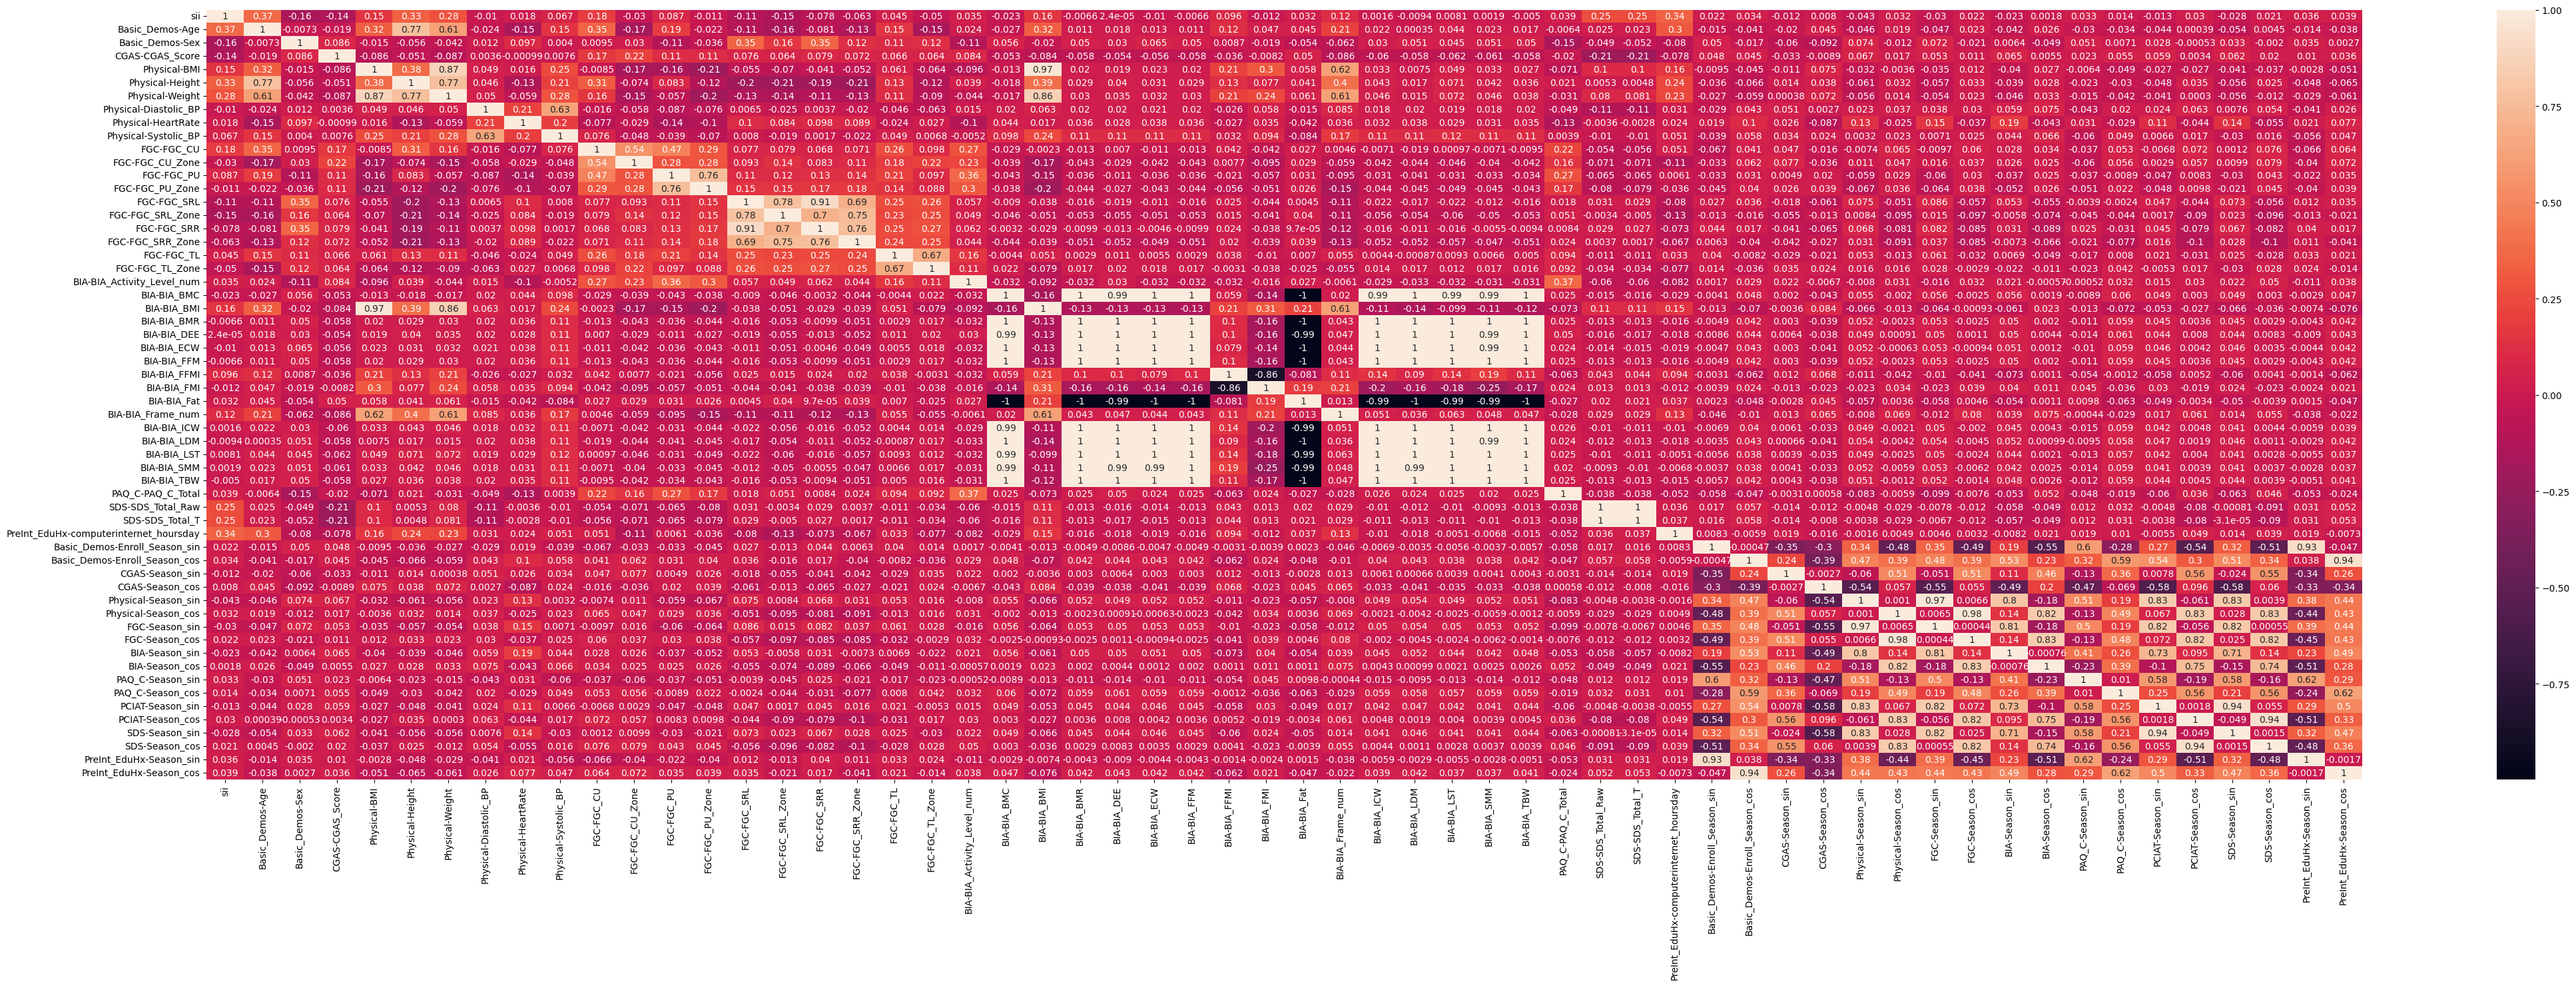

In [9]:
corr_wo_nulls_ = data_df.corr(False, dpi=15)


# MACHINE LEARNING

## Init

In [10]:
import polars.selectors as cs
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifier

ai_df = data_df.dataframe.select(pl.exclude(data_df.index_col))
# .filter(    pl.col("ResultadoDeLaLlamada").is_in(["CU+", "CU-", "CNU"]))

# prueba.to_csv('data_selected_modelo2.csv', index=False)
# df_final = pd.read_csv("data_selected_modelo2.csv")
target = "sii"
# Features/target split
target_data = ai_df.select(pl.col(target))
display(target_data.head())

input_data = ai_df.select(cs.exclude(target))
display(input_data.head())


sii
i64
2
0
0
1
1


Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Basic_Demos-Enroll_Season_sin,Basic_Demos-Enroll_Season_cos,CGAS-Season_sin,CGAS-Season_cos,Physical-Season_sin,Physical-Season_cos,FGC-Season_sin,FGC-Season_cos,BIA-Season_sin,BIA-Season_cos,PAQ_C-Season_sin,PAQ_C-Season_cos,PCIAT-Season_sin,PCIAT-Season_cos,SDS-Season_sin,SDS-Season_cos,PreInt_EduHx-Season_sin,PreInt_EduHx-Season_cos
i64,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
5,0,51,16.877316,46.0,50.8,null,null,null,0,0,0,0,7.0,0,6.0,0,6.0,1,2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,3,1.7485e-7,1.0,1.0,-4.3711e-8,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,null,null,1.7485e-7,1.0,null,null,1.7485e-7,1.0
9,0,null,14.03559,48.0,46.0,75,70,122,3,0,5,0,11.0,1,11.0,1,3.0,0,2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,2.34,46,64,0,-1.0,1.1925e-8,null,null,1.7485e-7,1.0,1.7485e-7,1.0,1.0,-4.3711e-8,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,-1.0,1.1925e-8
10,1,71,16.648696,56.5,75.6,65,94,117,20,1,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2.17,38,54,2,-1.0,1.1925e-8,1.7485e-7,1.0,1.7485e-7,1.0,1.7485e-7,1.0,null,null,-1.0,1.1925e-8,1.7485e-7,1.0,1.7485e-7,1.0,-1.0,1.1925e-8
9,0,71,18.292347,56.0,81.6,60,97,117,18,1,5,0,7.0,0,7.0,0,7.0,1,3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,2.451,31,45,0,1.0,-4.3711e-8,1.7485e-7,1.0,-1.0,1.1925e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,1.0,-4.3711e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,1.0,-4.3711e-8
13,1,50,22.279952,59.5,112.2,60,73,102,12,0,6,0,10.0,1,11.0,1,8.0,0,2,4.33036,30.1865,1330.97,1996.45,30.2124,84.0285,16.6877,13.4988,67.9715,2,32.9141,20.902,79.6982,35.3804,63.1265,4.11,40,56,0,-8.7423e-8,-1.0,1.0,-4.3711e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,-1.0,1.1925e-8,-8.7423e-8,-1.0,-1.0,1.1925e-8,-1.0,1.1925e-8,-8.7423e-8,-1.0


## Features importance

In [11]:
# Standarize the data to improve the regression's performance

# Define the model
import time
from collections.abc import Callable
from functools import wraps


def calc_time[**Args, R](func: Callable[Args, R]) -> Callable[Args, R]:
    @wraps(func)
    def wrapper(*args: Args.args, **kwargs: Args.kwargs) -> R:
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Execution time: {end_time - start_time} seconds")
        return result

    return wrapper


def feature_importances_calc(X, y) -> None:
    model = RandomForestClassifier(n_jobs=-1)

    # Fit the model
    calc_time(model.fit)(X, y.to_numpy().ravel())

    # Obtener las importancias de las características
    importances = model.feature_importances_

    # Crear un DataFrame para mostrar la importancia de cada característica
    feature_importances = pl.DataFrame({
        "Feature": X.columns,
        "Importance": importances,
    }).sort(
        by="Importance",
        descending=True,
    )

    display(feature_importances)


print("All Features:")
feature_importances_calc(input_data, target_data)


All Features:
Execution time: 0.16222786903381348 seconds


Feature,Importance
str,f64
"""SDS-SDS_Total_Raw""",0.040997
"""SDS-SDS_Total_T""",0.039955
"""Physical-Weight""",0.03897
"""PreInt_EduHx-computerinternet_…",0.037345
"""Basic_Demos-Age""",0.03659
…,…
"""FGC-FGC_SRR_Zone""",0.004696
"""FGC-FGC_CU_Zone""",0.004545
"""FGC-FGC_PU_Zone""",0.004191


## RandomForest

In [12]:
from numpy import ndarray
from sklearn.model_selection import train_test_split

# Train test split
print("Train test split")
data_split: tuple[pl.DataFrame, pl.DataFrame, ndarray, ndarray] = train_test_split(  # type: ignore
    input_data.select(sorted(input_data.columns)),
    target_data.to_numpy().ravel(),
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
input_train, input_test, target_train, target_test = data_split
print(f"X_train shape: {input_train.shape}")
print(f"X_test  shape: {input_test.shape}")
display(
    pl.Series(name="cats", values=target_train)
    .value_counts()
    .sort(by="count")
    .plot.bar(x="cats", y="count")
)


Train test split
X_train shape: (2188, 57)
X_test  shape: (548, 57)


alt.Chart(...)

## Predictions analysis

* Confusion matrix and testing metrics
* Output probabilities distribution
* Feature importances using different criteria

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from pretty_confusion_matrix import pp_matrix_from_data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    RocCurveDisplay,
    accuracy_score,
    fbeta_score,
    precision_score,
    recall_score,
)

display(target_test)
display(type(target_test))


def train_rnd_forest(X_train, y_train) -> RandomForestClassifier:
    print("Start training the model")
    model = RandomForestClassifier(
        class_weight="balanced_subsample",
        random_state=42,
    )
    model.fit(X_train, y_train)
    return model


def print_metrics(
    model: RandomForestClassifier,
    input_test: pl.DataFrame,
    target_test: ndarray,
) -> None:
    print("Model Predictions")
    predictions = model.predict(input_test)

    print("Accuracy: ", accuracy_score(target_test, predictions))
    print("Fbeta score: ", fbeta_score(target_test, predictions, beta=0.5, average="weighted"))
    print("Recall score: ", recall_score(target_test, predictions, average="weighted"))
    print("Precision score: ", precision_score(target_test, predictions, average="weighted"))

    figsize = len(model.classes_) + 2
    pp_matrix_from_data(
        target_test,
        predictions,
        columns=model.classes_.tolist(),
        cmap="PuRd",
        figsize=(figsize, figsize),
    )
    if len(model.classes_) == 2:
        RocCurveDisplay.from_estimator(
            model,
            input_test,
            target_test,
            pos_label=model.classes_[0],
        )
        plt.show()
        print()


def model_analisys(
    input_train: pl.DataFrame,
    target_train: ndarray,
    input_test: pl.DataFrame,
    target_test: ndarray,
    labels: list | None = None,
    model: RandomForestClassifier | None = None,
) -> tuple[RandomForestClassifier, tuple[ndarray, ndarray]]:
    data_train = target_train
    data_test = target_test

    if labels:
        others_labels = np.unique(target_train).tolist()

        correct_label = ",".join(map(str, labels))
        other_label = ",".join([label for label in others_labels if label not in labels])
        other_label = "Other" if len(other_label) > len(correct_label) * 1.5 else other_label

        conversor = np.vectorize(lambda x: correct_label if x in labels else other_label)
        data_train = conversor(data_train)
        data_test = conversor(data_test)

    labels = [str(label) for label in np.unique(data_train).tolist()]

    print(f"Model to classify [ {' | '.join(labels)} ]")
    if model is None:
        # model = train_rnd_forest(input_train, data_train)
        model = calc_time(train_rnd_forest)(input_train, data_train)
    print_metrics(model, input_test, data_test)
    return model, (data_train, data_test)


print("FULL Data    ", np.unique(target_train))
print()

# full category model
model, (data_train, data_test) = model_analisys(
    input_train,
    target_train,
    input_test,
    target_test,
)


ModuleNotFoundError: No module named 'pretty_confusion_matrix'

Feature,Importance
str,f64
"""Basic_Demos-Age""",0.048828
"""SDS-SDS_Total_T""",0.047281
"""Physical-Weight""",0.044432
"""SDS-SDS_Total_Raw""",0.040944
"""Physical-Height""",0.038938
…,…
"""FGC-FGC_SRR_Zone""",0.00429
"""FGC-FGC_PU_Zone""",0.004251
"""BIA-BIA_Frame_num""",0.003696


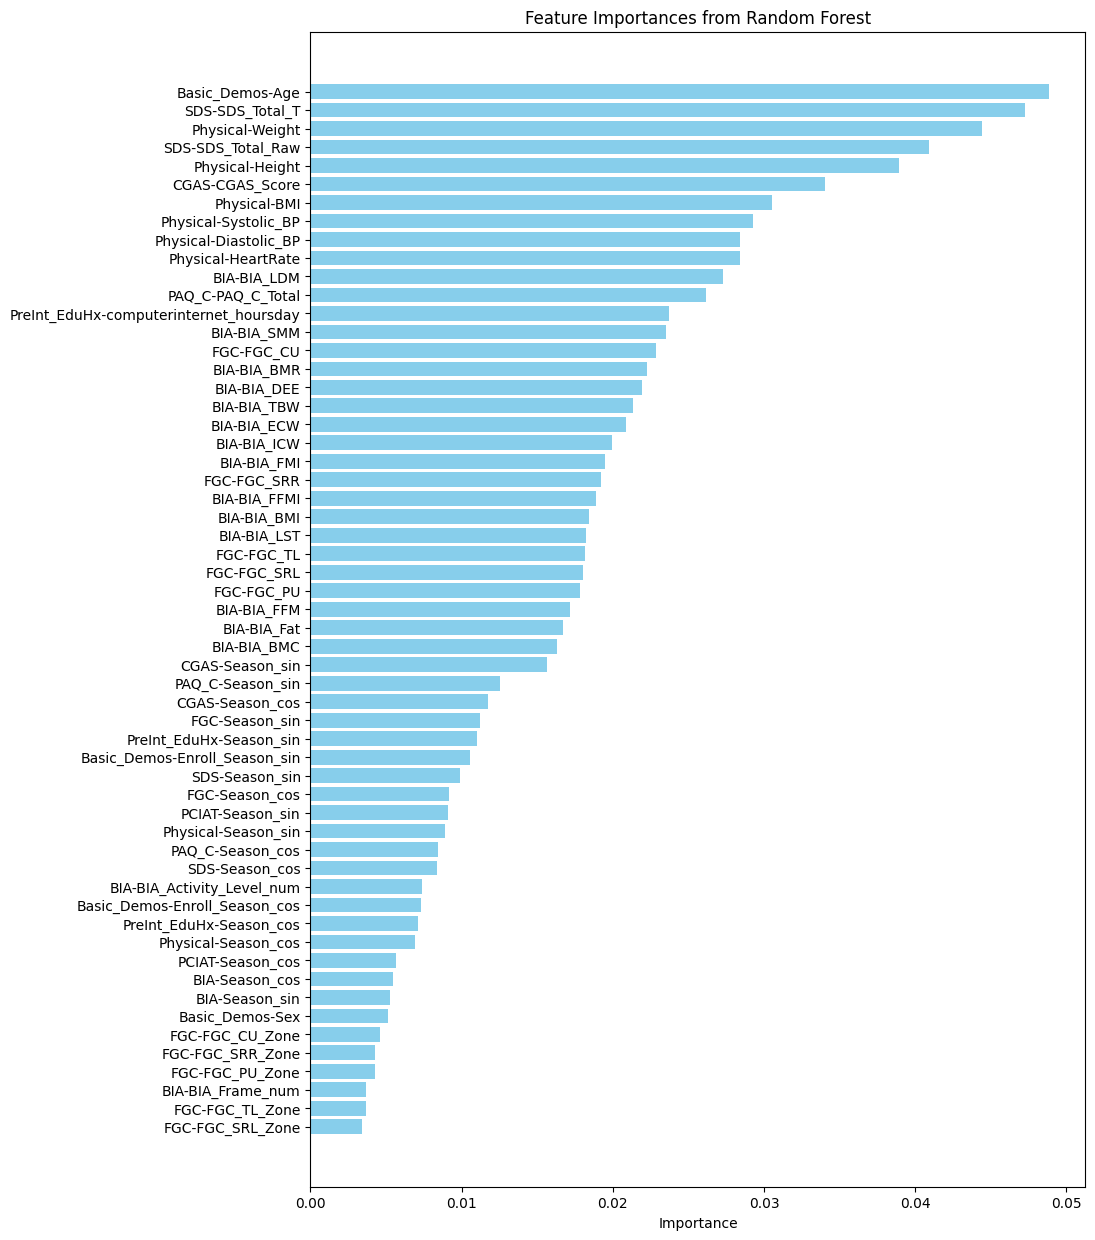

In [71]:
importances = model.feature_importances_

# Si tus datos tienen nombres de columnas (por ejemplo, si estás usando un DataFrame de pandas)
# De lo contrario, puedes usar una lista con los nombres de las características
features = input_train.columns

# Crear un DataFrame con las características y sus importancias
feature_importances = pl.DataFrame({"Feature": features, "Importance": importances})

# Ordenar por importancia
feature_importances = feature_importances.sort(by="Importance", descending=True)

# Mostrar el DataFrame
display(feature_importances)

# Graficar las importancias de las características
plt.figure(figsize=(10, 15))
plt.barh(feature_importances["Feature"], feature_importances["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.title("Feature Importances from Random Forest")
plt.gca().invert_yaxis()  # Para que las características más importantes estén en la parte superior
plt.show()


## Cross Validation

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

if True:
    # Definir el modelo de Random Forest
    rf_model = RandomForestClassifier(class_weight="balanced_subsample", random_state=42, n_jobs=-1)

    # Definir el número de folds para la validación cruzada (por ejemplo, 5)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Realizar la validación cruzada usando 'accuracy' como métrica
    print("Iniciando validación cruzada")
    print("---------------------------")

    cv_scores = cross_val_score(
        rf_model,
        input_train,
        target_train,
        cv=kfold,
        scoring="accuracy",
        n_jobs=-1,
    )
    # Mostrar los resultados
    print(f"Resultados de cada fold: {cv_scores}")
    print(f"Media de accuracy: {np.mean(cv_scores):.2f}")
    print(f"Desviación estándar de accuracy: {np.std(cv_scores):.2f}")

    print("---------------------------")
    print()

    # Comparar la media con el rendimiento en el conjunto de prueba
    print("Comparando con el conjunto de prueba")
    print("---------------------------")

    rf_model.fit(input_train, data_train)
    test_score = rf_model.score(input_test.select(sorted(input_test.columns)), data_test)
    print(f"Accuracy en el conjunto de prueba: {test_score:.2f}")

    print("---------------------------")


Iniciando validación cruzada
---------------------------
Resultados de cada fold: [0.5890411  0.57305936 0.57990868 0.61556064 0.58810069]
Media de accuracy: 0.59
Desviación estándar de accuracy: 0.01
---------------------------

Comparando con el conjunto de prueba
---------------------------
Accuracy en el conjunto de prueba: 0.62
---------------------------


# Estudios Individuales


In [73]:
import pandas as pd
from matplotlib.axes import Axes

compare_functions: list[Callable[[dict[str, pd.DataFrame], Axes], None]] = []


## Carlos


### Estudio X


## Jose Antonio


### Estudio Y


In [104]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

file_path = "../Data/CSV/train.csv"
df = pd.read_csv(file_path)
df.head()


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Limpieza y estandarización de datos

In [105]:
# Identificar columnas con más del 50% de valores nulos y eliminarlas
threshold = 0.5 * len(df)
columns_to_drop = df.columns[df.isnull().sum() > threshold]
df_cleaned = df.drop(columns=columns_to_drop)

# Imputación de valores faltantes en variables numéricas con la mediana
num_cols = df_cleaned.select_dtypes(include=["float64", "int64"]).columns
df_cleaned[num_cols] = df_cleaned[num_cols].fillna(df_cleaned[num_cols].median())

# Imputación de valores faltantes en variables categóricas con la moda
cat_cols = df_cleaned.select_dtypes(include=["object"]).columns
df_cleaned[cat_cols] = df_cleaned[cat_cols].fillna(df_cleaned[cat_cols].mode().iloc[0])

# Normalización
num_cols = df_cleaned.select_dtypes(include=["float64", "int64"]).columns.tolist()
num_cols.remove("sii")

# Aplicar Z-score normalization
scaler_standard = StandardScaler()
df_cleaned[num_cols] = scaler_standard.fit_transform(df_cleaned[num_cols])

# Aplicar normalización Min-Max (valores entre 0 y 1)
scaler_minmax = MinMaxScaler()
df_cleaned[num_cols] = scaler_minmax.fit_transform(df_cleaned[num_cols])


In [106]:
# Transformación de datos categóricos con One-Hot Encoding
cat_cols = df_cleaned.select_dtypes(include=["object"]).columns.tolist()
df_cleaned = pd.get_dummies(df_cleaned, columns=cat_cols, drop_first=True)


In [107]:
def eda_analysis(df: pd.DataFrame):
    """
    Realiza un Análisis Exploratorio de Datos (EDA):
    1. Calcula correlaciones entre variables.
    2. Identifica pares de columnas potencialmente interesantes.
    3. Genera gráficos de dispersión para visualizar tendencias, incluyendo explicaciones de las variables.
    """

    # Excluir columnas que comienzan con 'PCIAT' y con 'id_'
    filtered_columns = [
        col
        for col in df.columns
        if not col.startswith("PCIAT") and not col.startswith("id_") and col != "sii"
    ]
    df_filtered = df[filtered_columns]

    # Diccionario de descripciones de variables
    variable_descriptions = {
        "BIA-BIA_BMR": "Basal Metabolic Rate (Tasa Metabólica Basal)",
        "BIA-BIA_FFM": "Fat-Free Mass (Masa Libre de Grasa)",
        "BIA-BIA_TBW": "Total Body Water (Agua Corporal Total)",
        "BIA-BIA_ECW": "Extracellular Water (Agua Extracelular)",
        "BIA-BIA_ICW": "Intracellular Water (Agua Intracelular)",
        "BIA-BIA_LDM": "Lean Dry Mass (Masa Magra Seca)",
        "BIA-BIA_SMM": "Skeletal Muscle Mass (Masa Muscular Esquelética)",
        "BIA-BIA_BMC": "Bone Mineral Content (Contenido Mineral Óseo)",
        "BIA-BIA_LST": "Lean Soft Tissue (Tejido Magro Blando)",
        "BIA-BIA_DEE": "Daily Energy Expenditure (Gasto Energético Diario)",
        "BIA-BIA_Fat": "Body Fat Mass (Masa Grasa Corporal)",
        "Physical-BMI": "Índice de Masa Corporal (BMI)",
        "Physical-Systolic_BP": "Presión Arterial Sistólica",
        "Physical-HeartRate": "Frecuencia Cardíaca",
        "Basic_Demos-Age": "Edad del participante",
        "Basic_Demos-Sex": "Sexo del participante",
        "PreInt_EduHx-computerinternet_hoursday": "Horas diarias de uso de Internet",
        "PreInt_EduHx-Season_Spring": "Estación del año: Primavera",
        "Physical-Season_Spring": "Actividad física en primavera",
        "Physical-Season_Winter": "Actividad física en invierno",
        "SDS-Season_Spring": "Escala de trastornos del sueño en primavera",
        "SDS-Season_Summer": "Escala de trastornos del sueño en verano",
        "SDS-SDS_Total_": "Total Sleep Disturbance Scale (Total SDS Score)",
        "SDS-SDS_Total_Raw": "Total Sleep Disturbance Scale (Puntuación Bruta)",
        "CGAS-CGAS_Score": "Children's Global Assessment Scale (CGAS Score)",
        "FGC-FGC_CU": "FitnessGram Curl-Up (Abdominales)",
        "FGC-FGC_CU_Zone": "Zona FitnessGram Curl-Up",
        "FGC-FGC_PU": "FitnessGram Push-Up (Flexiones)",
        "FGC-FGC_PU_Zone": "Zona FitnessGram Push-Up",
        "FGC-FGC_SRL_Zone": "Zona FitnessGram Shoulder Reach Left",
        "FGC-FGC_PU_Zone": "Zona FitnessGram Push-Up",
        "FGC-Season_Spring": "FitnessGram en primavera",
        "CGAS-Season_Winter": "CGAS Score en invierno",
        "BIA-Season_Summer": "Bioimpedancia en verano",
    }

    # Calcular la matriz de correlación
    correlation_matrix = df_filtered.corr()

    # Identificar pares de columnas con alta correlación
    correlated_pairs = []
    threshold = 0.5  # Umbral de correlación relevante
    for col1 in correlation_matrix.columns:
        for col2 in correlation_matrix.columns:
            if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold:
                correlated_pairs.append((
                    col1,
                    col2,
                    correlation_matrix.loc[col1, col2],
                    variable_descriptions.get(col1, col1),
                    variable_descriptions.get(col2, col2),
                ))

    # Convertir a DataFrame
    df_correlated_pairs = pd.DataFrame(
        correlated_pairs,
        columns=["Variable 1", "Variable 2", "Correlación", "Descripción 1", "Descripción 2"],
    )
    df_correlated_pairs = df_correlated_pairs.sort_values(by="Correlación", ascending=False)

    # Exportar a CSV
    df_correlated_pairs.to_csv("../Data/correlated_pairs.csv", index=False)

    print("Pares de columnas con correlación significativa:")
    display(df_correlated_pairs)

    return df_correlated_pairs


eda_analysis(df_cleaned)


Pares de columnas con correlación significativa:


,Variable 1,Variable 2,Correlación,Descripción 1,Descripción 2
75,BIA-BIA_FFM,BIA-BIA_BMR,1.000000,Fat-Free Mass (Masa Libre de Grasa),Basal Metabolic Rate (Tasa Metabólica Basal)
47,BIA-BIA_BMR,BIA-BIA_FFM,1.000000,Basal Metabolic Rate (Tasa Metabólica Basal),Fat-Free Mass (Masa Libre de Grasa)
139,BIA-BIA_TBW,BIA-BIA_BMR,0.999603,Total Body Water (Agua Corporal Total),Basal Metabolic Rate (Tasa Metabólica Basal)
53,BIA-BIA_BMR,BIA-BIA_TBW,0.999603,Basal Metabolic Rate (Tasa Metabólica Basal),Total Body Water (Agua Corporal Total)
83,BIA-BIA_FFM,BIA-BIA_TBW,0.999603,Fat-Free Mass (Masa Libre de Grasa),Total Body Water (Agua Corporal Total)
...,...,...,...,...,...
91,BIA-BIA_Fat,BIA-BIA_FFM,-0.975541,Body Fat Mass (Masa Grasa Corporal),Fat-Free Mass (Masa Libre de Grasa)
113,BIA-BIA_LDM,BIA-BIA_Fat,-0.981780,Lean Dry Mass (Masa Magra Seca),Body Fat Mass (Masa Grasa Corporal)
93,BIA-BIA_Fat,BIA-BIA_LDM,-0.981780,Body Fat Mass (Masa Grasa Corporal),Lean Dry Mass (Masa Magra Seca)
34,BIA-BIA_BMC,BIA-BIA_Fat,-0.991255,Bone Mineral Content (Contenido Mineral Óseo),Body Fat Mass (Masa Grasa Corporal)


,Variable 1,Variable 2,Correlación,Descripción 1,Descripción 2
75,BIA-BIA_FFM,BIA-BIA_BMR,1.000000,Fat-Free Mass (Masa Libre de Grasa),Basal Metabolic Rate (Tasa Metabólica Basal)
47,BIA-BIA_BMR,BIA-BIA_FFM,1.000000,Basal Metabolic Rate (Tasa Metabólica Basal),Fat-Free Mass (Masa Libre de Grasa)
139,BIA-BIA_TBW,BIA-BIA_BMR,0.999603,Total Body Water (Agua Corporal Total),Basal Metabolic Rate (Tasa Metabólica Basal)
53,BIA-BIA_BMR,BIA-BIA_TBW,0.999603,Basal Metabolic Rate (Tasa Metabólica Basal),Total Body Water (Agua Corporal Total)
83,BIA-BIA_FFM,BIA-BIA_TBW,0.999603,Fat-Free Mass (Masa Libre de Grasa),Total Body Water (Agua Corporal Total)
...,...,...,...,...,...
91,BIA-BIA_Fat,BIA-BIA_FFM,-0.975541,Body Fat Mass (Masa Grasa Corporal),Fat-Free Mass (Masa Libre de Grasa)
113,BIA-BIA_LDM,BIA-BIA_Fat,-0.981780,Lean Dry Mass (Masa Magra Seca),Body Fat Mass (Masa Grasa Corporal)
93,BIA-BIA_Fat,BIA-BIA_LDM,-0.981780,Body Fat Mass (Masa Grasa Corporal),Lean Dry Mass (Masa Magra Seca)
34,BIA-BIA_BMC,BIA-BIA_Fat,-0.991255,Bone Mineral Content (Contenido Mineral Óseo),Body Fat Mass (Masa Grasa Corporal)


Procesando grupo: grupo_principal


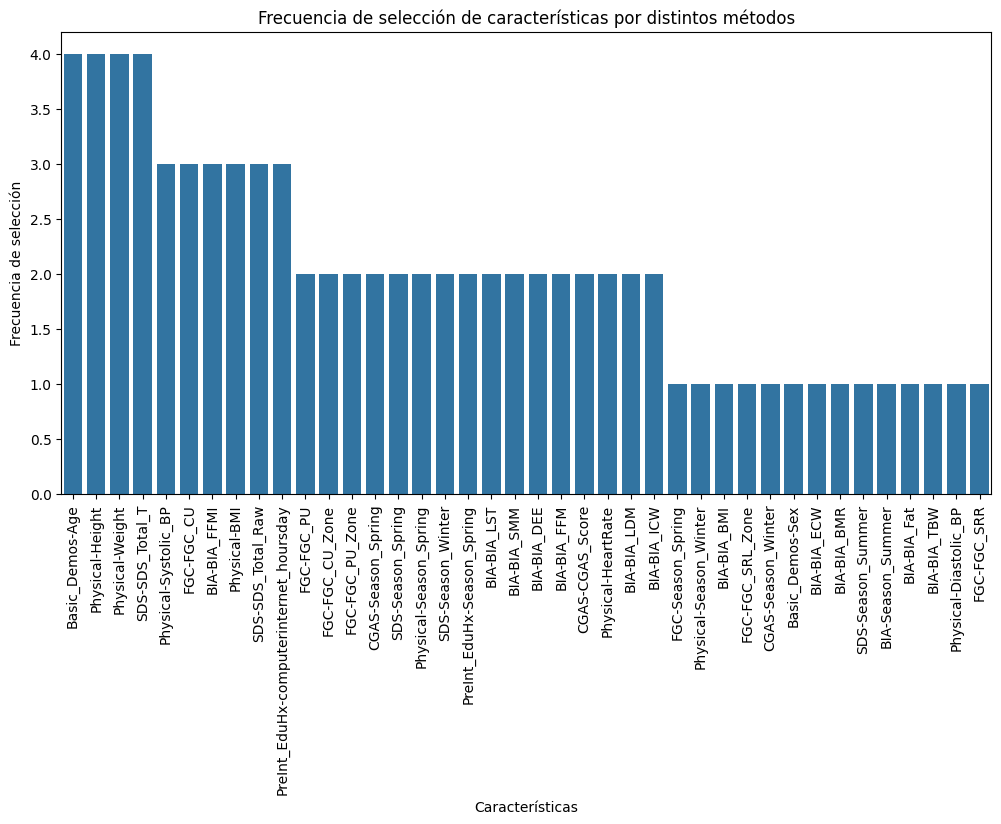

,Característica,Frecuencia
0,Basic_Demos-Age,4
2,Physical-Height,4
3,Physical-Weight,4
13,SDS-SDS_Total_T,4
4,Physical-Systolic_BP,3
5,FGC-FGC_CU,3
11,BIA-BIA_FFMI,3
1,Physical-BMI,3
12,SDS-SDS_Total_Raw,3
14,PreInt_EduHx-computerinternet_hoursday,3


In [108]:
def mi_analysis(dfs: dict[str, pd.DataFrame]):
    """
    Realiza un análisis ejecutando varios métodos de seleccion de características para ayudarnos a decidir que caracterísitcas tienen más impacto en sii
    1. Ejecuta los diferentes métodos
    2. Hace una gráfica para comparar las características que se repiten más por cada método.
    3. Muestra una tabla con la comparativa
    """

    resultados = {}

    for grupo, df in dfs.items():
        print(f"Procesando grupo: {grupo}")

        # Excluir columnas que comienzan con 'PCIAT' y con 'id_'
        filtered_columns = [
            col
            for col in df.columns
            if not col.startswith("PCIAT") and not col.startswith("id_") and col != "sii"
        ]
        df_cleaned = df[filtered_columns + ["sii"]].dropna()
        X = df_cleaned.drop(columns=["sii"])
        y = df_cleaned["sii"]

        feature_scores = {}

        # ANOVA F-test
        selector = SelectKBest(score_func=f_classif, k=20)
        selector.fit(X, y)
        feature_scores["ANOVA F-test"] = X.columns[selector.get_support()]

        # Chi-cuadrado
        selector = SelectKBest(score_func=chi2, k=20)
        selector.fit(X, y)
        feature_scores["Chi-Cuadrado"] = X.columns[selector.get_support()]

        # Mutual Information
        selector = SelectKBest(score_func=mutual_info_classif, k=20)
        selector.fit(X, y)
        feature_scores["Mutual Information"] = X.columns[selector.get_support()]

        # Random Forest
        rf = RandomForestClassifier().fit(X, y)
        feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
        feature_scores["Random Forest"] = feature_importances.nlargest(20).index

        # Guardar resultados
        resultados[grupo] = feature_scores

    # Contar cuántas veces aparece cada característica
    feature_counts = {}
    for metodo in resultados[next(iter(resultados))]:
        for feature in resultados[next(iter(resultados))][metodo]:
            feature_counts[feature] = feature_counts.get(feature, 0) + 1

    df_feature_counts = pd.DataFrame(
        list(feature_counts.items()), columns=["Característica", "Frecuencia"]
    )
    df_feature_counts = df_feature_counts.sort_values(by="Frecuencia", ascending=False)

    # Crear gráfico
    plt.figure(figsize=(12, 6))
    sns.barplot(x=df_feature_counts["Característica"], y=df_feature_counts["Frecuencia"])
    plt.xticks(rotation=90)
    plt.xlabel("Características")
    plt.ylabel("Frecuencia de selección")
    plt.title("Frecuencia de selección de características por distintos métodos")
    plt.show()

    return df_feature_counts


# Llamar a la función
dfs = {"grupo_principal": df_cleaned}
resultados = mi_analysis(dfs)
display(resultados)


## Santiago


### Estudio Z

In [109]:
def bmi_bpm(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos Physical-BMI y Phisical-HeartRate
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    for i, (name, df) in enumerate(dfs.items()):
        ax.scatter(
            df["Physical-BMI"],
            df["Physical-HeartRate"],
            label=name,
            color=colormap(i),
        )

    plt.xlabel("Physical-BMI")
    plt.ylabel("Physical-HeartRate")
    ax.legend()


compare_functions.append(bmi_bpm)


def bmi_fat(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos Physical-BMI y BIA-BIA_Fat
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    def filter(df):
        return df[df["BIA-BIA_Fat"] > 0]

    def compose_values(df):
        total = df["BIA-BIA_Fat"] + df["BIA-BIA_FFM"]
        return (df["BIA-BIA_Fat"] / total) * 100

    for i, (name, df) in enumerate(dfs.items()):
        data = filter(df)
        ax.scatter(
            data["Physical-BMI"],
            compose_values(data),
            label=name,
            color=colormap(i),
        )
    plt.xlabel("Physical-BMI")
    plt.ylabel("BIA-BIA_Fat")
    ax.legend()


compare_functions.append(bmi_fat)


def bpm_fat(dfs: dict[str, pd.DataFrame], ax: Axes):
    """Genera graficas comparativas para todos los Dataframes
    en la misma grafica diferenciados por colores
    comparando (x,y) los campos Physical-HeartRate y BIA-BIA_Fat
    """
    colormap = plt.get_cmap("tab20", len(dfs))

    def filter(df):
        return df[df["BIA-BIA_Fat"] > 0]

    def compose_values(df):
        total = df["BIA-BIA_Fat"] + df["BIA-BIA_FFM"]
        return (df["BIA-BIA_Fat"] / total) * 100

    for i, (name, df) in enumerate(dfs.items()):
        data = filter(df=df)
        ax.scatter(
            data["Physical-HeartRate"],
            compose_values(data),
            label=name,
            color=colormap(i),
        )

    plt.xlabel("Physical-HeartRate")
    plt.ylabel("BIA-BIA_Fat")
    ax.legend()


compare_functions.append(bpm_fat)


# Ejecucion de Comparaciones


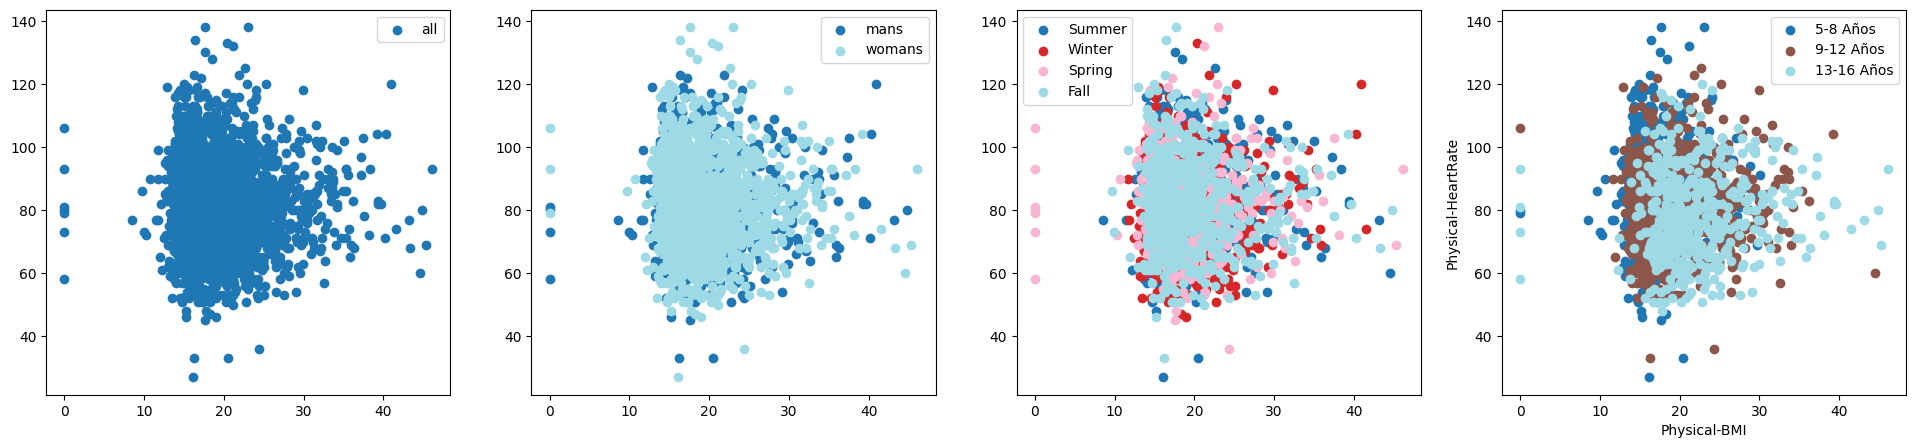

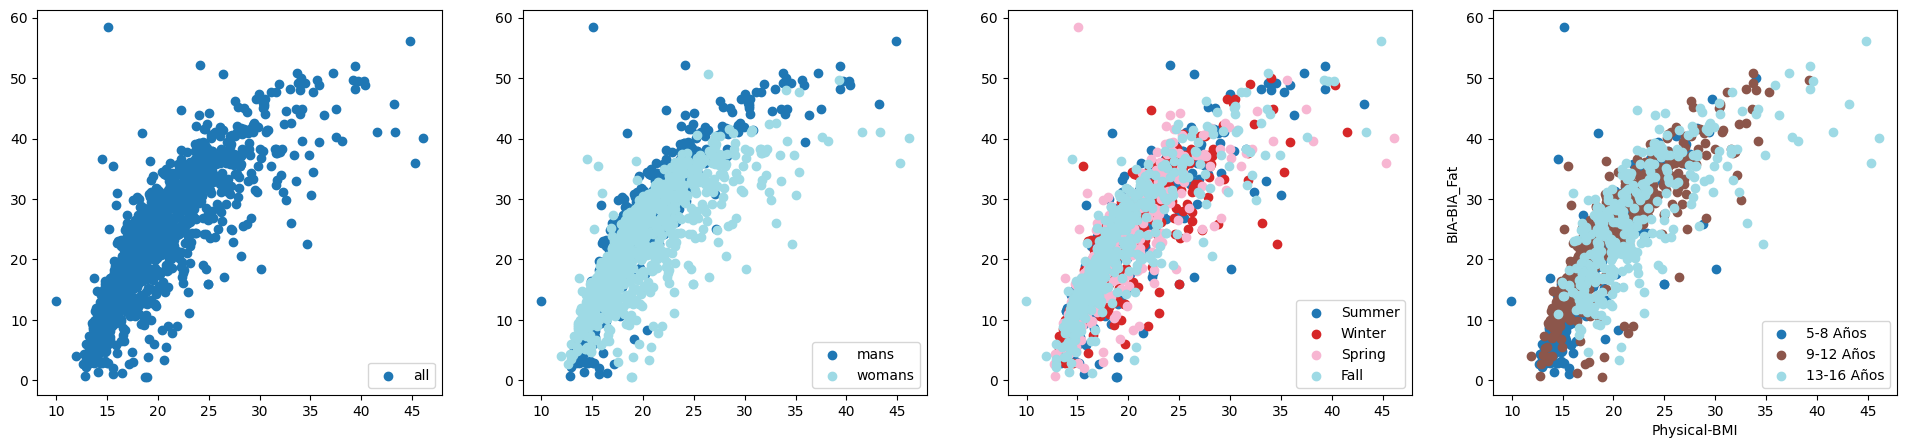

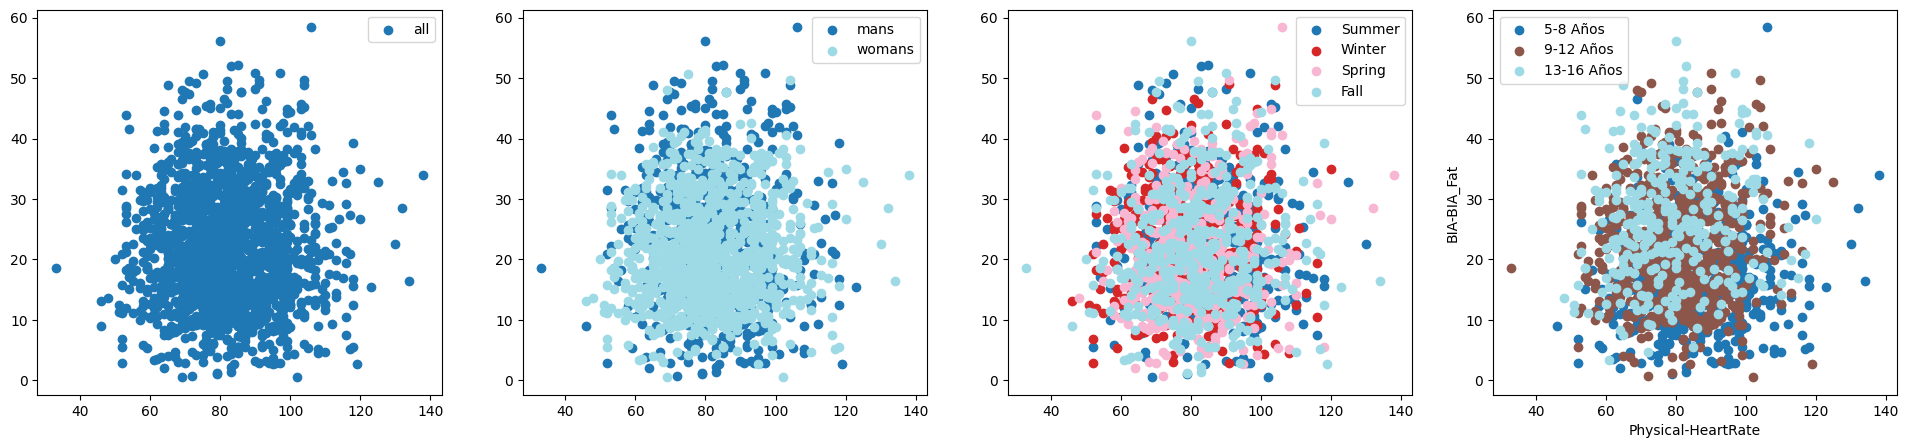

In [110]:
comparative_data: list[dict[str, pd.DataFrame]] = []

# EJEMPLOS 1
data_dict = {"all": input_data.to_pandas()}
comparative_data.append(data_dict)

# EJEMPLOS 2
data_dict = {}
data_dict["mans"] = input_data.filter(pl.col("Basic_Demos-Sex") == 1).to_pandas()
data_dict["womans"] = input_data.filter(pl.col("Basic_Demos-Sex") == 0).to_pandas()
comparative_data.append(data_dict)

# EJEMPLOS 3
data_dict = {}
data_dict["Summer"] = input_data.filter(pl.col("Physical-Season_sin") == 1.0).to_pandas()
data_dict["Winter"] = input_data.filter(pl.col("Physical-Season_sin") == -1.0).to_pandas()
data_dict["Spring"] = input_data.filter(pl.col("Physical-Season_cos") == 1.0).to_pandas()
data_dict["Fall"] = input_data.filter(pl.col("Physical-Season_cos") == -1.0).to_pandas()
comparative_data.append(data_dict)

# EJEMPLOS 4
data_dict = {}
data_dict["5-8 Años"] = input_data.filter(
    pl.col("Basic_Demos-Age").is_in(list(range(5, 9)))
).to_pandas()
data_dict["9-12 Años"] = input_data.filter(
    pl.col("Basic_Demos-Age").is_in(list(range(9, 13)))
).to_pandas()
data_dict["13-16 Años"] = input_data.filter(
    pl.col("Basic_Demos-Age").is_in(list(range(13, 17)))
).to_pandas()

comparative_data.append(data_dict)

for compare_function in compare_functions:
    fig, ax = plt.subplots(1, len(comparative_data), figsize=(len(comparative_data) * 6, 5))
    for i, data_dict in enumerate(comparative_data):
        compare_function(data_dict, ax[i])
